In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transformed_adata = sc.read_h5ad("/home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/models/fa_100/transformed_data.h5ad")

In [3]:
print(transformed_adata.obs['predicted.annotation'].value_counts())
print(transformed_adata.obs['CN.label'].value_counts())

CLP         12181
MEP-EP      10533
HSC/MPP2     6627
cDC          5403
NP2          4690
NP1          4649
pDC2         4612
LMPP         3212
pDC1         3071
HSC/MPP1     1832
EBM          1366
ncMono       1073
MEP-MkP       869
Name: predicted.annotation, dtype: int64
normal    58550
cancer     1568
Name: CN.label, dtype: int64


In [4]:
transformed_adata

AnnData object with n_obs × n_vars = 60118 × 15918
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.wsnn_res.0.5.score', 'predicted.wsnn_res.0.5', 'predicted.wsnn_res.0.8.score', 'predicted.wsnn_res.0.8', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'MEP-EP', 'pDC2', 'NP1', 'cDC', 'LMPP', 'pDC1', 'NP2', 'ncMono', 'HSC/MPP1', 'HSC/MPP2', 'EBM', 'MEP-MkP', 'CLP', 'mapping_entropy', 'primary_cell_type', 'primary_max_score', 'secondary_cell_type', 'second_max_score', 'l1', 'l2', 'CN.label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_c

In [5]:
transformed_adata.obsm['X_fa'].shape

(60118, 100)

In [6]:
# --- settings ---
PATIENT = "P02"  # set to None to use all cells
FACTOR_1BASED = 46
FACTOR_IDX = FACTOR_1BASED - 1
SCORE_KEY = f"Factor_{FACTOR_1BASED}_score"

# --- subset (optional) ---
adata_plot = transformed_adata
if PATIENT is not None:
    adata_plot = transformed_adata[transformed_adata.obs["patient"] == PATIENT].copy()

# --- add factor score to .obs for plotting ---
adata_plot.obs[SCORE_KEY] = adata_plot.obsm["X_fa"][:, FACTOR_IDX].astype(float)

# --- compute embeddings from factor space ---
# Build neighbor graph using factor scores
sc.pp.neighbors(
    adata_plot,
    use_rep="X_fa",
    n_neighbors=15,
    metric="cosine",
)

# UMAP embedding
sc.tl.umap(adata_plot, random_state=0)

# Graph layout embedding
# We *request* ForceAtlas2 via layout='fa', but Scanpy 1.11 will fall back to 'fr'
# unless `fa2-modified` is installed.
sc.tl.draw_graph(adata_plot, layout="fa", random_state=0)

# Detect what was actually computed so plotting won’t error.
if "X_draw_graph_fa" in adata_plot.obsm:
    DRAW_GRAPH_LAYOUT = "fa"  # ForceAtlas2
elif "X_draw_graph_fr" in adata_plot.obsm:
    DRAW_GRAPH_LAYOUT = "fr"  # fallback
else:
    raise RuntimeError(
        "No draw_graph embedding found in `adata_plot.obsm`. "
        "Expected `X_draw_graph_fa` or `X_draw_graph_fr`."
    )

adata_plot

AnnData object with n_obs × n_vars = 1462 × 15918
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.wsnn_res.0.5.score', 'predicted.wsnn_res.0.5', 'predicted.wsnn_res.0.8.score', 'predicted.wsnn_res.0.8', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'MEP-EP', 'pDC2', 'NP1', 'cDC', 'LMPP', 'pDC1', 'NP2', 'ncMono', 'HSC/MPP1', 'HSC/MPP2', 'EBM', 'MEP-MkP', 'CLP', 'mapping_entropy', 'primary_cell_type', 'primary_max_score', 'secondary_cell_type', 'second_max_score', 'l1', 'l2', 'CN.label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_co

## ForceAtlas2 dependency (Scanpy 1.11)

With **Scanpy 1.11**, `sc.tl.draw_graph(..., layout='fa')` uses ForceAtlas2 only if **`fa2-modified`** is installed. If it’s missing, Scanpy **silently falls back to `fr`** (Fruchterman–Reingold) and stores `X_draw_graph_fr` instead of `X_draw_graph_fa`.

Recommended install in your conda env:

```bash
conda install -c conda-forge scanpy python-igraph leidenalg
python -m pip install fa2-modified
```

Note: `pip install ForceAtlas2` is a different package name and is **not** what Scanpy 1.11 looks for here.

In [7]:
adata_plot

AnnData object with n_obs × n_vars = 1462 × 15918
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.wsnn_res.0.5.score', 'predicted.wsnn_res.0.5', 'predicted.wsnn_res.0.8.score', 'predicted.wsnn_res.0.8', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'MEP-EP', 'pDC2', 'NP1', 'cDC', 'LMPP', 'pDC1', 'NP2', 'ncMono', 'HSC/MPP1', 'HSC/MPP2', 'EBM', 'MEP-MkP', 'CLP', 'mapping_entropy', 'primary_cell_type', 'primary_max_score', 'secondary_cell_type', 'second_max_score', 'l1', 'l2', 'CN.label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_co

In [8]:
DRAW_GRAPH_LAYOUT

'fa'

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


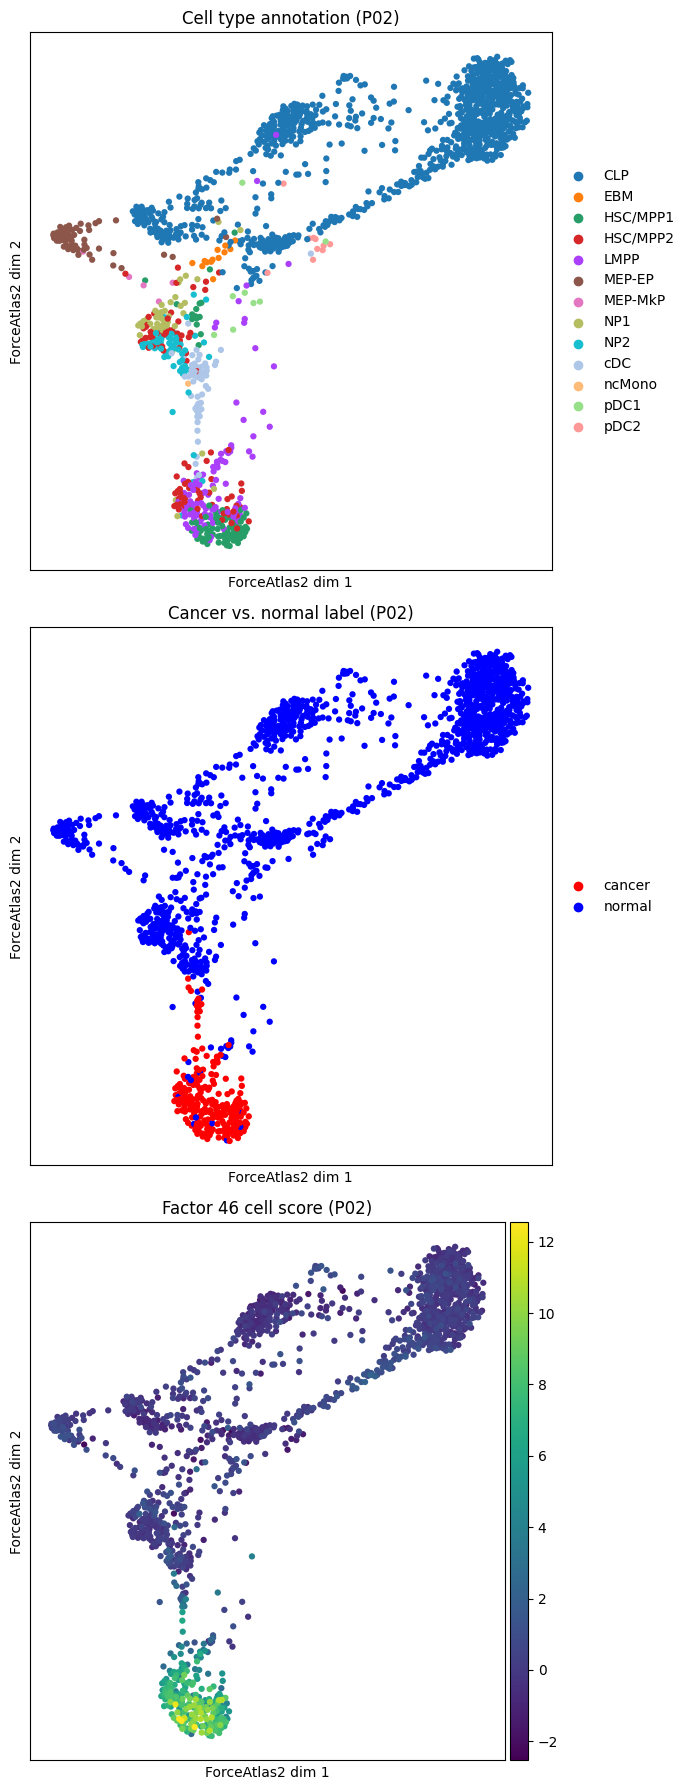

In [9]:
# --- 3-panel plot: ForceAtlas2 (draw_graph) ---
# Make CN.label colors match the reference: cancer=red, normal=blue
CN_PALETTE = {"cancer": "red", "normal": "blue"}
adata_plot.obs["CN.label"] = pd.Categorical(
    adata_plot.obs["CN.label"], categories=["cancer", "normal"]
)

layout_label = "ForceAtlas2" if DRAW_GRAPH_LAYOUT == "fa" else "Fruchterman–Reingold (fallback)"

fig, axs = plt.subplots(3, 1, figsize=(7, 18))

sc.pl.draw_graph(
    adata_plot,
    layout=DRAW_GRAPH_LAYOUT,
    color="predicted.annotation",
    title=f"Cell type annotation ({PATIENT})",
    ax=axs[0],
    show=False,
    frameon=True,
    legend_loc="right margin",
)

sc.pl.draw_graph(
    adata_plot,
    layout=DRAW_GRAPH_LAYOUT,
    color="CN.label",
    palette=CN_PALETTE,
    title=f"Cancer vs. normal label ({PATIENT})",
    ax=axs[1],
    show=False,
    frameon=True,
    legend_loc="right margin",
)

sc.pl.draw_graph(
    adata_plot,
    layout=DRAW_GRAPH_LAYOUT,
    color=SCORE_KEY,
    color_map="viridis",
    title=f"Factor {FACTOR_1BASED} cell score" + (f" ({PATIENT})" if PATIENT is not None else ""),
    ax=axs[2],
    show=False,
    frameon=True,
)

# Axis labels + full rectangular frame
xlab = "ForceAtlas2 dim 1" if DRAW_GRAPH_LAYOUT == "fa" else f"{layout_label} dim 1"
ylab = "ForceAtlas2 dim 2" if DRAW_GRAPH_LAYOUT == "fa" else f"{layout_label} dim 2"
for ax in axs:
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set_visible(True)

plt.tight_layout()

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


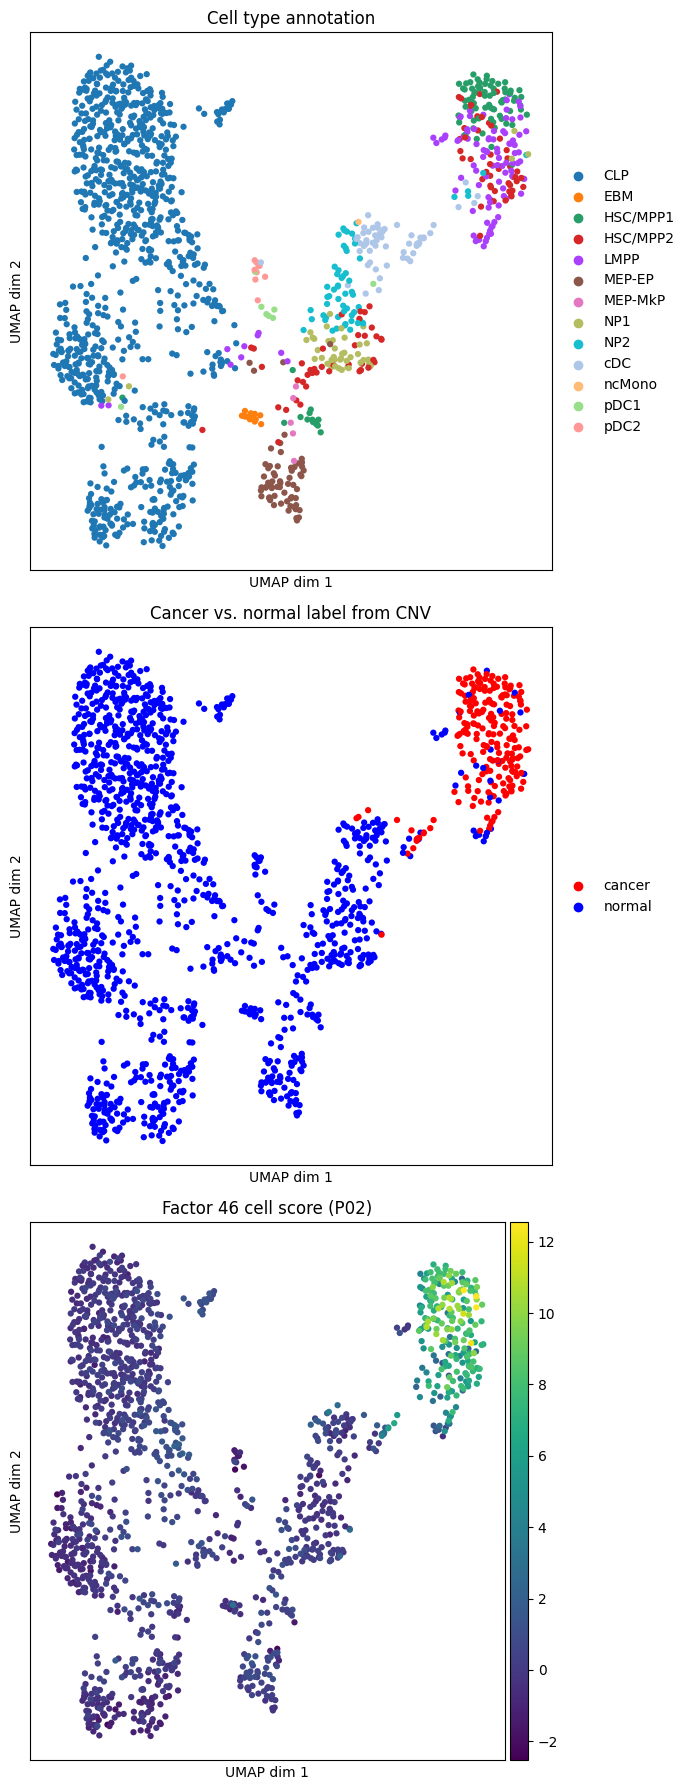

In [10]:
# --- 3-panel plot: UMAP ---
# Reuse the same CN label palette for consistent comparison
CN_PALETTE = {"cancer": "red", "normal": "blue"}
adata_plot.obs["CN.label"] = pd.Categorical(
    adata_plot.obs["CN.label"], categories=["cancer", "normal"]
)

fig, axs = plt.subplots(3, 1, figsize=(7, 18))

sc.pl.umap(
    adata_plot,
    color="predicted.annotation",
    title="Cell type annotation",
    ax=axs[0],
    show=False,
    frameon=True,
    legend_loc="right margin",
)

sc.pl.umap(
    adata_plot,
    color="CN.label",
    palette=CN_PALETTE,
    title="Cancer vs. normal label from CNV",
    ax=axs[1],
    show=False,
    frameon=True,
    legend_loc="right margin",
)

sc.pl.umap(
    adata_plot,
    color=SCORE_KEY,
    color_map="viridis",
    title=f"Factor {FACTOR_1BASED} cell score" + (f" ({PATIENT})" if PATIENT is not None else ""),
    ax=axs[2],
    show=False,
    frameon=True,
)

for ax in axs:
    ax.set_xlabel("UMAP dim 1")
    ax.set_ylabel("UMAP dim 2")
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set_visible(True)

plt.tight_layout()